In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jd_comment_with_label/jd_comment_data.xlsx


In [45]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from torch.utils.data import random_split
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# 读取 Excel 文件
file_path = '/kaggle/input/jd_comment_with_label/jd_comment_data.xlsx'
df = pd.read_excel(file_path)

comments_list = []
scores_list = []

# 遍历 DataFrame 的每一行
for index, row in df.iterrows():
    # 提取每行的数据并放入字典
    comment = row['评价内容(content)']
    score = 1 if row['评分（总分5分）(score)'] > 3 else 0
    # score = row['评分（总分5分）(score)'] - 1

    if (comment == '此用户未填写评价内容'):
        continue

    comments_list.append(comment)
    scores_list.append(score)

print(comments_list[:5])
print(scores_list[:5])

['一般般，一分钱一分货吧', '商品质量很好，很满意，配送速度快啊，而且配送员态度也非常好。', '。。。', '刘慧敏提莫摸摸摸休息泽TCL退咯的一组婆婆破鼓规土局', '还好还好还好还好红红火火好很好好']
[0, 1, 1, 1, 1]


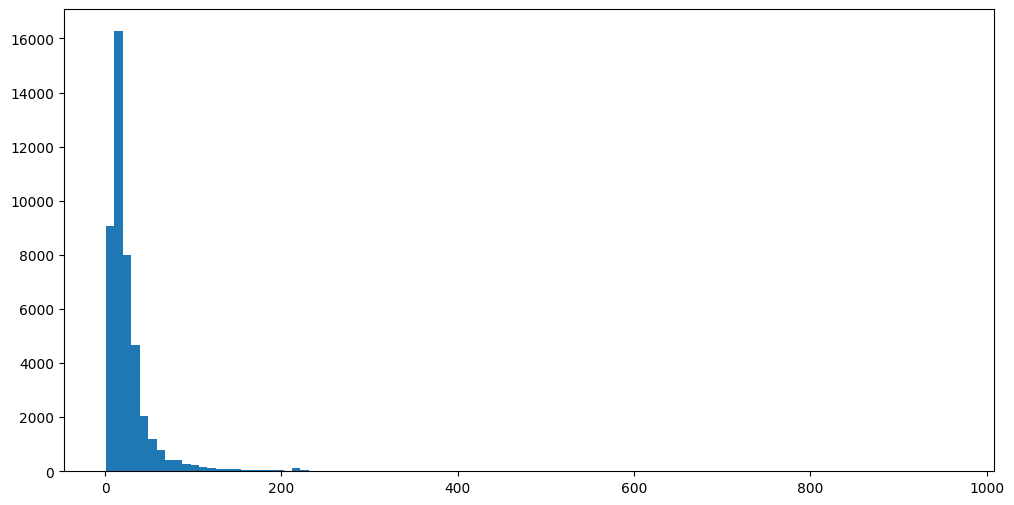

44422


In [4]:
plt.figure(figsize=(12, 6))

comments_len = [len(comment) for comment in comments_list]
plt.hist(comments_len, bins=100)
plt.show()

print(len(comments_list))

In [5]:
comments_zip_list = list(zip(comments_list, scores_list))

print(comments_zip_list[:5])

[('一般般，一分钱一分货吧', 0), ('商品质量很好，很满意，配送速度快啊，而且配送员态度也非常好。', 1), ('。。。', 1), ('刘慧敏提莫摸摸摸休息泽TCL退咯的一组婆婆破鼓规土局', 1), ('还好还好还好还好红红火火好很好好', 1)]


In [6]:
comments_zip_list1 = [c for c in comments_zip_list if len(c[0]) in range(10, 100)]

print(len(comments_zip_list1))
print(comments_zip_list1[:5])

35388
[('一般般，一分钱一分货吧', 0), ('商品质量很好，很满意，配送速度快啊，而且配送员态度也非常好。', 1), ('刘慧敏提莫摸摸摸休息泽TCL退咯的一组婆婆破鼓规土局', 1), ('还好还好还好还好红红火火好很好好', 1), ('好好好好好好好好，好好好好好很好', 1)]


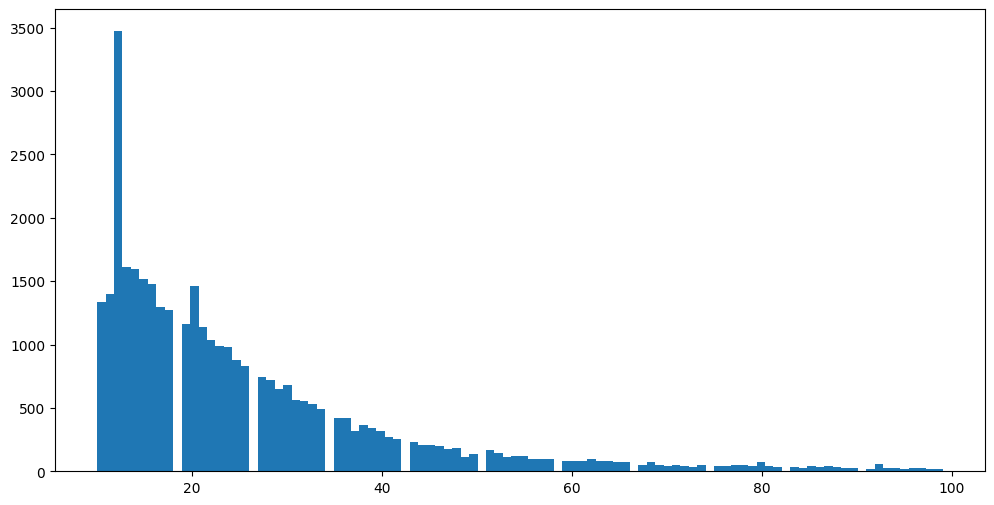

In [7]:
plt.figure(figsize=(12, 6))

comments_len1 = [len(comment) for comment, score in comments_zip_list1]
plt.hist(comments_len1, bins=100)
plt.show()

In [8]:
class Comments_Dataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
 
    def __len__(self):
        return len(self.datasets)
 
    def __getitem__(self, idx):
        comment, score = self.datasets[idx]

        return comment, torch.tensor(score, dtype=torch.long)

In [9]:
bert_cls_model = AutoModelForSequenceClassification.from_pretrained('google-bert/bert-base-chinese', 
                                                            num_labels=2)
print(bert_cls_model)

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [10]:
# 加载词典创建分词器
tokenizer=  AutoTokenizer.from_pretrained('google-bert/bert-base-chinese')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

In [11]:
def get_proc(tokenizer):
    def collate_fn(batch):
        comments, labels = zip(*batch)
        # tokenizer转换
        model_inputs = tokenizer(comments, return_tensors='pt', padding = True,  truncation = True)
        labels = torch.tensor(labels, dtype=torch.long)

        return model_inputs, labels
    return collate_fn

In [44]:
datasets = Comments_Dataset(comments_zip_list1)

dataloader = DataLoader(datasets, batch_size=10, shuffle=True, collate_fn=get_proc(tokenizer))

# 测试
model_input = []
label = []

for model_inputs, labels in dataloader:
    model_input = model_inputs
    print("Comments:", model_input)
    print()
    label = labels
    print("Scores:", label)
    print()
    break

output = bert_cls_model(**model_input)
logits = output.logits
print("logits:", logits)
print()

# 获取预测结果
probabilities = torch.softmax(logits, dim=-1)  # 对 logits 调用 softmax
predicted_classes = torch.argmax(probabilities, dim=-1)  # 获取每个样本的预测类别
 
print(predicted_classes)

Comments: {'input_ids': tensor([[  101,  2923,   679,  7231,  4638,  8024,  2697,  6230,  6820,  1377,
           809,  8024,  2376,  3301,  1351,   743,  4638,  8024,  3301,  1351,
          2523,  1599,  3614,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  101,   671,  5663,  5663,  1416,  3766,  3300,   792,  5305,  4638,
          1962,  8024,  6820,  4026,  1355,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  101,  2644,  3766,  3300,  1856,  1091,  1079,  2159,  8024,  7949,
          6371,  1962,  6397,   102,     0,     0,     0,     0,     0,  

### 数据拆分

In [13]:
dataset_size = len(datasets)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(datasets, [train_size, test_size])

print(len(train_dataset))
print(len(test_dataset))

torch.save(train_dataset, 'train_dataset.bin')
torch.save(test_dataset, 'test_dataset.bin')

28310
7078


### 未训练模型，原生 bert_cls_model 测试

In [53]:
def bare_model_test(dataloader, device):
    model = bert_cls_model
    model = model.to(device)
    model.eval()

    correct_predictions = 0

    eval_cnt = 0

    with torch.no_grad():
        for model_inputs, labels in dataloader:
            model_inputs = {k: v.to(device) for k, v in model_inputs.items()}
            labels = labels.to(device)
    
            outputs = model(**model_inputs)
            logits_eval = outputs.logits

            # print("logits_eval:", logits_eval)
    
            # 获取预测结果
            probabilities = torch.softmax(logits_eval, dim=-1)  # 对 logits 调用 softmax
            # print("probabilities:", probabilities)
            
            predicted_classes = torch.argmax(probabilities, dim=-1)  # 获取每个样本的预测类别
            
            # print("predicted_classes:", predicted_classes)
            
            correct_predictions += (predicted_classes == labels).sum().item()
            eval_cnt += 1
            if (eval_cnt % 10 == 0):
                print(f"[{eval_cnt}]模型预测的正确数量: {correct_predictions:.2f}")
            
        accuracy = correct_predictions / test_size
        print(f"模型预测的正确率: {accuracy * 100:.2f}%")

In [46]:
test_dataloader = DataLoader(test_dataset, batch_size=128, 
                         shuffle=False, collate_fn=get_proc(tokenizer))

In [54]:
bare_model_test(test_dataloader, device)

[10]模型预测的正确数量: 1210.00
[20]模型预测的正确数量: 2421.00
[30]模型预测的正确数量: 3639.00
[40]模型预测的正确数量: 4840.00
[50]模型预测的正确数量: 6037.00
模型预测的正确率: 94.42%


### bert 分类模型训练

In [14]:
LR = 1e-5
EPOCHS = 5
BATCH_SIZE = 128

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                         shuffle=True, collate_fn=get_proc(tokenizer))

cuda


In [15]:
def model_train(epochs, dataloader, model, Freeze_enable = False):
    if (Freeze_enable == True):
        # 冻结bert参数
        for param in model.bert.parameters():
            param.requires_grad = False

    train_loss_cnt = 0

    # 优化器、损失
    optimizer = optim.AdamW(model.parameters(), weight_decay=0.01, lr=LR)
    criterion = nn.CrossEntropyLoss()

    if (Freeze_enable == True):
        log_path = '/kaggle/working/logs/Freeze_enable/'
    elif (Freeze_enable == False):
        log_path = '/kaggle/working/logs/Freeze_disable/'

    writer = SummaryWriter(log_path)

    for epoch in range(epochs):
        model.train()
        tpbar = tqdm(dataloader)
        for model_inputs, labels in tpbar:
            model_inputs = {k: v.to(device) for k, v in model_inputs.items()}
            labels = labels.to(device)

            # 前向传播
            output = model(**model_inputs)
            logits = output.logits
                 
            # 计算损失
            loss = criterion(logits, labels)
    
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            tpbar.set_description(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

            if (Freeze_enable == True):
                writer.add_scalar('Freeze_enable Loss/train', loss.item(), train_loss_cnt)
            else:
                writer.add_scalar('Freeze_disable Loss/train', loss.item(), train_loss_cnt)
            train_loss_cnt += 1

    if (Freeze_enable == True):
        torch.save(model.state_dict(), 'Freeze_enable_bert_cls_model.bin')
    else:
        torch.save(model.state_dict(), 'Freeze_disable_bert_cls_model.bin')

In [16]:
#  冻结bert参数
bert_cls_model1 = AutoModelForSequenceClassification.from_pretrained('google-bert/bert-base-chinese', 
                                                            num_labels=2).to(device)

model_train(EPOCHS, train_dataloader, bert_cls_model1, Freeze_enable = True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 5, Loss: 0.1906: 100%|██████████| 222/222 [01:13<00:00,  3.00it/s]


In [17]:
#  不冻结bert参数
bert_cls_model2 = AutoModelForSequenceClassification.from_pretrained('google-bert/bert-base-chinese', 
                                                            num_labels=2).to(device)

model_train(EPOCHS, train_dataloader, bert_cls_model2, Freeze_enable = False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 5, Loss: 0.0010: 100%|██████████| 222/222 [03:43<00:00,  1.01s/it]


1. 使用冻结bert参数，模型训练速度快，损失下降不明显
2. 使用冻结bert参数，模型训练速度慢，损失下降明显

In [18]:
# 下载工作目录文件
import os
import zipfile
from IPython.display import FileLink

def zip_folder(folder_path, zip_path):
    """压缩目录为 ZIP 文件，排除目标 ZIP 文件本身"""
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                # 跳过目标 ZIP 文件
                if file_path == zip_path:
                    continue
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

# 压缩 /kaggle/working 目录
zip_folder('/kaggle/working', '/kaggle/working/output.zip')

# 生成下载链接
FileLink('output.zip')

/kaggle/working/output.zip

### bert 模型预测

In [39]:
def model_test(dataloader, device, Freeze_enable = False):
    bert_cls_model = AutoModelForSequenceClassification.from_pretrained('google-bert/bert-base-chinese', 
                                                            num_labels=2).to(device)

    if (Freeze_enable == True):
        state_dict = torch.load('/kaggle/working/Freeze_enable_bert_cls_model.bin', map_location=device)
    elif (Freeze_enable == False):
        state_dict = torch.load('/kaggle/working/Freeze_disable_bert_cls_model.bin', map_location=device)

    bert_cls_model.load_state_dict(state_dict)
    
    bert_cls_model.eval()

    correct_predictions = 0

    eval_cnt = 0

    with torch.no_grad():
        for model_inputs, labels in dataloader:
            model_inputs = {k: v.to(device) for k, v in model_inputs.items()}
            labels = labels.to(device)
    
            outputs = bert_cls_model(**model_inputs)
            logits_eval = outputs.logits

            # print("logits_eval:", logits_eval)
    
            # 获取预测结果
            probabilities = torch.softmax(logits_eval, dim=-1)  # 对 logits 调用 softmax
            # print("probabilities:", probabilities)
            
            predicted_classes = torch.argmax(probabilities, dim=-1)  # 获取每个样本的预测类别
            
            # print("predicted_classes:", predicted_classes)
            
            correct_predictions += (predicted_classes == labels).sum().item()
            eval_cnt += 1
            if (eval_cnt % 10 == 0):
                print(f"[{eval_cnt}]模型预测的正确数量: {correct_predictions:.2f}")
            
        accuracy = correct_predictions / test_size
        print(f"模型预测的正确率: {accuracy * 100:.2f}%")

In [40]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                         shuffle=False, collate_fn=get_proc(tokenizer))

In [41]:
# 使用冻结 bert 参数的模型预测
model_test(test_dataloader, device, Freeze_enable = True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[10]模型预测的正确数量: 1232.00
[20]模型预测的正确数量: 2466.00
[30]模型预测的正确数量: 3701.00
[40]模型预测的正确数量: 4934.00
[50]模型预测的正确数量: 6159.00
模型预测的正确率: 96.24%


In [43]:
# 使用未冻结 bert 参数的模型预测
model_test(test_dataloader, device, Freeze_enable = False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[10]模型预测的正确数量: 1235.00
[20]模型预测的正确数量: 2465.00
[30]模型预测的正确数量: 3695.00
[40]模型预测的正确数量: 4923.00
[50]模型预测的正确数量: 6162.00
模型预测的正确率: 96.27%
